<div id='slide00'>
    <img src="./images/title.svg" />
</div>

<div id='slide01'>
    <img src="./images/motivation_all.svg" />
</div>

<div id='slide02'>
    <img src="./images/features_all.svg" />
</div>

<div id="slide03">
    <img src="./images/example_create_lattice_cpu_tracking_header.svg" />
</div>

In [1]:
import sixtracklib as st

# Build a Fodo Lattice
lattice = st.Elements()
quad_f  = lattice.Multipole(knl=[0.0, 0.165])
drift01 = lattice.Drift(length=10.0)
quad_d  = lattice.Multipole(knl=[0.0, -0.165])
drift02 = lattice.Drift(length=10.0)
  
# Create a beam with a set of particles for tracking
beam = st.ParticlesSet()
particles = beam.Particles(num_particles=10, p0c=4.5e11)

# Save lattice and particle states to files for later re-use
lattice.to_file('./example_lattice.bin')
beam.to_file('./example_particles.bin')

# Create a CPU SixTrackLib TrackJob 
job = st.TrackJob(lattice, beam)

status = job.track_until( 1 )

job.collect_particles()
print( f"particles at_turn: {particles.at_turn}")

particles at_turn: [1 1 1 1 1 1 1 1 1 1]



<div id="slide05">
    <img src="./images/example_madx_header.svg" />
</div>


In [2]:
# Using cpymad and pysixtrack
from cpymad.madx import Madx
import numpy as np
import pysixtrack as pyst

m_p = 938e6 # [m_p] = 1 eV
c0 = 299792458.0 # [c0] = 1 m/s

beam = st.ParticlesSet()
p0c = 450e9 # [p0c] = 1 eV
Etot = np.sqrt( p0c * p0c + m_p * m_p * c0 ** 4 ) * 1e-9 # [Etot] = 1 GeV !!!
particles = beam.Particles(num_particles=10, p0c=4.5e11)

mad = Madx()
mad.call(file="fodo.madx")
mad.command.beam(particle="proton", energy=str(Etot))
mad.use(sequence="FODO")

fodo = mad.sequence.FODO

pyst_line = pyst.Line.from_madx_sequence(fodo, exact_drift=True)
pyst_line.remove_zero_length_drifts(inplace=True)

lattice = st.Elements()
lattice.append_line( pyst_line )

# .... Continue like above ... 


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2020.02.27 10:35:30      +
  ++++++++++++++++++++++++++++++++++++++++++++
! Element definitions:

! ------------------- horizontal quadrupole ----------------------------

QUAD_F: MULTIPOLE, KNL={0, 0.165};

QUAD_D: MULTIPOLE, KNL={0,-0.165};



FODO: SEQUENCE, L=20.0, REFER=entry;

   QF1: QUAD_F, AT=10.0;

   QD1: QUAD_D, AT=20.0;

ENDSEQUENCE;



	





<div id="slide06">
    <img src="./images/example_opencl_tracking_header.svg" />
</div>

In [3]:
# Same lattice and beam definition, but now track on an OpenCL device
# First: find out which devices are available
!clinfo -l

Platform #0: Portable Computing Language
 `-- Device #0: pthread-Intel(R) Core(TM) i5-5300U CPU @ 2.30GHz
Platform #1: Intel(R) OpenCL
 +-- Device #0: Intel(R) HD Graphics
 `-- Device #1: Intel(R) Core(TM) i5-5300U CPU @ 2.30GHz
Platform #2: Experimental OpenCL 2.1 CPU Only Platform
 `-- Device #0: Intel(R) Core(TM) i5-5300U CPU @ 2.30GHz


In [4]:
# Then create an OpenCL track-job using one of the devices
lattice = st.Elements.fromfile('./example_lattice.bin')
beam = st.ParticlesSet.fromfile( './example_particles.bin')
cl_job = st.TrackJob(lattice, beam, device="opencl:2.0")

# The rest is like before
status = cl_job.track_until( 2 )
cl_job.collect_particles()

particles = beam.cbuffer.get_object(0)
print( f"particles at_turn: {particles.at_turn}")

particles at_turn: [2 2 2 2 2 2 2 2 2 2]


In [5]:
import pandas

times_header = ['num_particles', 'num_turns', 'repetitions', 'num_workitems', 'workgroup_size', 
                'time', 'num_lost_particles', 'min_time', 'min_time_lost_particles', 'max_time',
                'max_time_lost_particles', 'total_time']

files = {}

# pcbe-abp-agpu001
files["pcbe-abp-gpu001"] = {}
files["pcbe-abp-gpu001"]["cpu"] = pandas.read_csv(
    "./benchmarks/pcbe-abp-gpu001/pcbe_abp_gpu001__lhc_nobb__cpu__ryzen2970wx_cpu__all_cpu_node_20200226_102437_cxx.times", 
    delimiter=r"\s+", comment="#", header=None, names=times_header)
files["pcbe-abp-gpu001"]["ocl_titanv_all"] = pandas.read_csv(
    "./benchmarks/pcbe-abp-gpu001/pcbe_abp_gpu001__lhc_no_bb__opencl0.1__titan_v_00__all_opencl_node0.1_20200226_214148_cxx.times",
    delimiter=r"\s+", comment="#", header=None, names=times_header)
files["pcbe-abp-gpu001"]["ocl_titanv_none"] = pandas.read_csv(
    "./benchmarks/pcbe-abp-gpu001/pcbe_abp_gpu001__lhc_no_bb__opencl0.1__titan_v_00__none_opencl_node0.1_20200226_214817_cxx.times",
    delimiter=r"\s+", comment="#", header=None, names=times_header)
files["pcbe-abp-gpu001"]["ocl_ryzen2970wx_pocl_all"] = pandas.read_csv(
    "./benchmarks/pcbe-abp-gpu001/pcbe_abp_gpu001__lhc_no_bb__opencl1.0__ryzen2970wx_pocl__all_opencl_node1.0_20200226_081341_cxx.times",
    delimiter=r"\s+", comment="#", header=None, names=times_header)
files["pcbe-abp-gpu001"]["ocl_ryzen2970wx_pocl_none"] = pandas.read_csv(
    "./benchmarks/pcbe-abp-gpu001/pcbe_abp_gpu001__lhc_no_bb__opencl1.0__ryzen2970wx_pocl__none_opencl_node1.0_20200225_181816_cxx.times",
    delimiter=r"\s+", comment="#", header=None, names=times_header)

# pcbe15600
files["pcbe15600"] = {}
files["pcbe15600"]["cpu"] = pandas.read_csv(
    "./benchmarks/pcbe15600/pcbe15600__lhc_nobb__cpu__ryzen1950x_cpu__all_cpu_node_20200226_104543_cxx.times", 
    delimiter=r"\s+", comment="#", header=None, names=times_header)
files["pcbe15600"]["ocl_ryzen1950x_intel_all"] = pandas.read_csv(
    "./benchmarks/pcbe15600/pcbe15600__lhc_nobb__opencl2.0__ryzen1950xintel__all_opencl_node2.0_20200226_083410_cxx.times", 
    delimiter=r"\s+", comment="#", header=None, names=times_header)
files["pcbe15600"]["ocl_ryzen1950x_intel_none"] = pandas.read_csv(
    "./benchmarks/pcbe15600/pcbe15600__lhc_nobb__opencl2.0__ryzen1950xintel__none_opencl_node2.0_20200226_091513_cxx.times", 
    delimiter=r"\s+", comment="#", header=None, names=times_header)
files["pcbe15600"]["ocl_titanv_all"] = pandas.read_csv(
    "./benchmarks/pcbe15600/pcbe15600__lhc_nobb__opencl0.0__titan_v__all__opt_opencl_node0.0_20200225_142401_cxx.times", 
    delimiter=r"\s+", comment="#", header=None, names=times_header)
files["pcbe15600"]["ocl_titanv_none"] = pandas.read_csv(
    "./benchmarks/pcbe15600/pcbe15600__lhc_nobb__titan_v__none_opencl_node0.0_20200225_143049_cxx.times", 
    delimiter=r"\s+", comment="#", header=None, names=times_header)
files["pcbe15600"]["ocl_radeonvii_all"] = pandas.read_csv(
    "./benchmarks/pcbe15600/pcbe15600__lhc_nobb__opencl1.0__radeon_vii__all_opencl_node1.0_20200226_233157_cxx.times", 
    delimiter=r"\s+", comment="#", header=None, names=times_header)
files["pcbe15600"]["ocl_radeonvii_none"] = pandas.read_csv(
    "./benchmarks/pcbe15600/pcbe15600__lhc_nobb__opencl1.0__radeon_vii__none_opencl_node1.0_20200226_235006_cxx.times", 
    delimiter=r"\s+", comment="#", header=None, names=times_header)

# pcbe16820
files["pcbe16820"] = {}
files["pcbe16820"]["ocl_gtx1050ti_all"] = pandas.read_csv(    
    "./benchmarks/pcbe16820/pcbe16820__lhc_no_bb__opencl2.0__gtx1050ti_all_opencl_node2.0_20200225_114656_cxx.times", 
    delimiter=r"\s+", comment="#", header=None, names=times_header)




<div id="slide07">
    <img src="./images/performance_analysis_1_header.svg" />
</div>

In [6]:
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator

def plot_cpu_comparison(plt, data):
    ax = plt.plot(
        data["pcbe-abp-gpu001"]["cpu"]["num_particles"], data["pcbe-abp-gpu001"]["cpu"]["time"],
        label='AMD Threadripper 2970wx CPU', color='k', marker='*', markevery=1)
    plt.plot(
        data["pcbe15600"]["cpu"]["num_particles"], data["pcbe15600"]["cpu"]["time"],
        label='AMD Threadripper 1950x CPU', color='gray', marker='^', markevery=1)
    
    plt.xlim(1,1e6)
    plt.ylim(0.0,1e-3)    
    plt.yscale('linear')
    plt.xscale('log')
    plt.xlabel('Numbers of Particles Np (log)',fontsize="14")
    plt.ylabel('Tracking Duration / turn / particle [ms]',fontsize="14" )
    plt.title('LHC Lattice incl. Imperfections but without 6D/4D Beam-Beam, SC Elements',fontsize="20")
        
    plt.tick_params(axis='x', labelsize='12')
    plt.tick_params(axis='y', labelsize='12')
    plt.ticklabel_format(axis='y',style='sci',scilimits=(-3,-3))
    plt.text(1.2,0.4e-3,"(Less Is Better, Expected: Flat Curve)", fontsize="14", color="k", rotation=90)
    
    ax = plt.gca()
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    
    plt.grid(True, which='major', axis='x')
    plt.grid(True, which='major', axis='y')
    plt.grid(True, which='minor', axis='y', linestyle=':')
    
    plt.legend(fontsize=12, loc='lower left')
    return plt


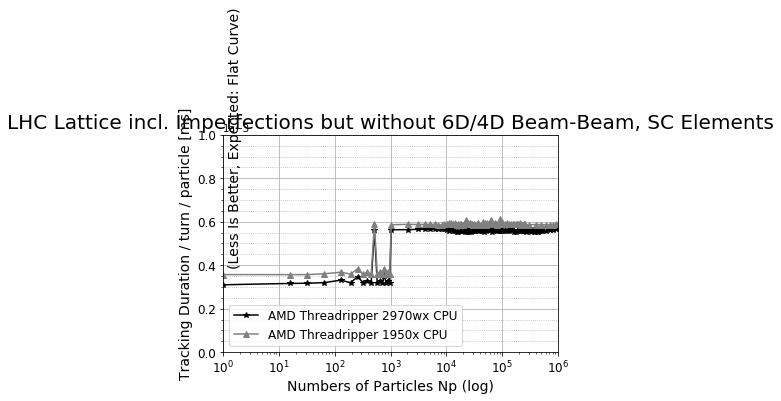

In [7]:
plt = plot_cpu_comparison(plt, files)
plt.rcParams["figure.figsize"]=(16,9)

<div id="slide07">
    <img src="./images/performance_analysis_1_header.svg" />
</div>

In [8]:
def plot_cpu_vs_ocl_all_enabled(plt, data):
    plt.plot(
        data["pcbe-abp-gpu001"]["cpu"]["num_particles"], data["pcbe-abp-gpu001"]["cpu"]["time"],
        label='AMD Threadripper 2970wx CPU', color='k', marker='*', markevery=1)
    plt.plot(
        data["pcbe15600"]["cpu"]["num_particles"], data["pcbe15600"]["cpu"]["time"],
        label='AMD Threadripper 1950x CPU', color='gray', marker='^', markevery=1)
    plt.plot(
        data["pcbe-abp-gpu001"]["ocl_titanv_all"]["num_particles"], 
        data["pcbe-abp-gpu001"]["ocl_titanv_all"]["time"],
        label='NVIDIA Titan V', color='#7b85d4', marker='+', markevery=1)
    plt.plot(
        data["pcbe-abp-gpu001"]["ocl_ryzen2970wx_pocl_all"]["num_particles"], 
        data["pcbe-abp-gpu001"]["ocl_ryzen2970wx_pocl_all"]["time"],
        label='AMD 2970wx OpenCL (POCL)', color='#83c995', marker='<', markevery=1)
    plt.plot(
        data["pcbe15600"]["ocl_ryzen1950x_intel_all"]["num_particles"], 
        data["pcbe15600"]["ocl_ryzen1950x_intel_all"]["time"],
        label='AMD 1950x OpenCL (Intel)', color='#e9d043', marker='<', markevery=1)
    plt.plot(
        data["pcbe15600"]["ocl_radeonvii_all"]["num_particles"], 
        data["pcbe15600"]["ocl_radeonvii_all"]["time"],
        label='AMD Radeon VII', color='#859795', marker='x', markevery=1)
    plt.plot(
        data["pcbe16820"]["ocl_gtx1050ti_all"]["num_particles"], 
        data["pcbe16820"]["ocl_gtx1050ti_all"]["time"],
        label='NVIDIA GTX 1050Ti', color='#f37738', marker='o', markevery=1)    
    
    plt.xlim(1,1e6)
    plt.ylim(0.0,1e-3)
    plt.yscale('linear')
    plt.xscale('log')
    plt.xlabel('Numbers of Particles Np (log)',fontsize="14")
    plt.ylabel('Tracking Duration / turn / particle [ms]',fontsize="14" )
    plt.title('LHC Lattice incl. Imperfections but without 6D/4D Beam-Beam, SC Elements',fontsize="20")
    
    plt.tick_params(axis='x', labelsize='12')
    plt.tick_params(axis='y', labelsize='12')
    plt.ticklabel_format(axis='y',style='sci',scilimits=(-3,-3))
    plt.text(1.2,0.4e-3,"(Less Is Better, Expected: Flat Curve)", fontsize="14", color="k", rotation=90)
    
    ax = plt.gca()
    ax.yaxis.set_minor_locator(AutoMinorLocator(4))
    
    plt.grid(True, which='major', axis='x')
    plt.grid(True, which='major', axis='y')
    plt.grid(True, which='minor', axis='y', linestyle=':')
    
    plt.legend(fontsize=12, loc='upper right')
    return plt

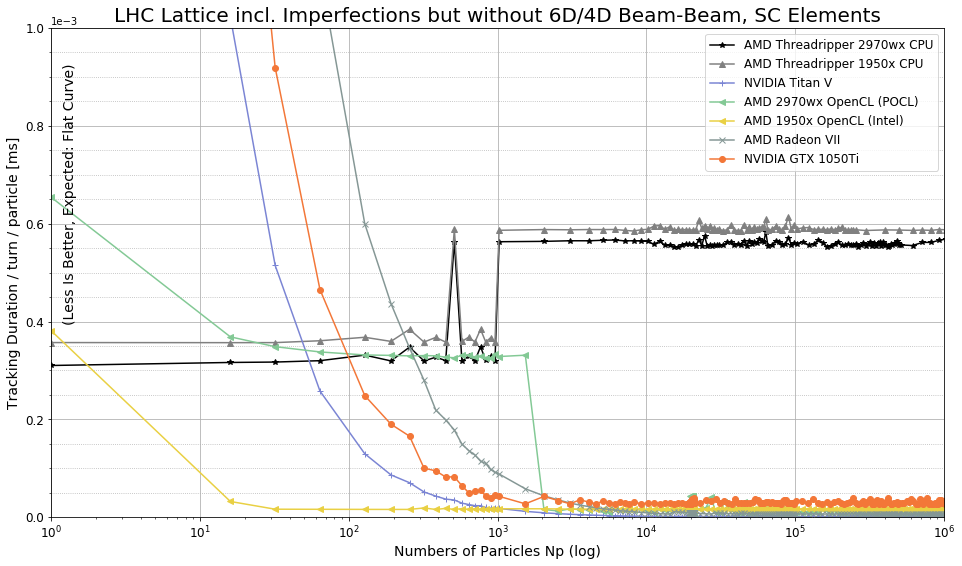

In [9]:
plt = plot_cpu_vs_ocl_all_enabled(plt, files)
plt.rcParams["figure.figsize"]=(16,9)

<div id="slide07">
    <img src="./images/performance_analysis_1_header.svg" />
</div>

In [10]:
def plot_cpu_vs_ocl_all_enabled_log_log(plt, data):
    ax = plt.plot(
        data["pcbe-abp-gpu001"]["cpu"]["num_particles"], data["pcbe-abp-gpu001"]["cpu"]["time"],
        label='AMD Threadripper 2970wx CPU', color='k', marker='*', markevery=1)
    plt.plot(
        data["pcbe15600"]["cpu"]["num_particles"], data["pcbe15600"]["cpu"]["time"],
        label='AMD Threadripper 1950x CPU', color='gray', marker='^', markevery=1)
    plt.plot(
        data["pcbe-abp-gpu001"]["ocl_titanv_all"]["num_particles"], 
        data["pcbe-abp-gpu001"]["ocl_titanv_all"]["time"],
        label='NVIDIA Titan V', color='#7b85d4', marker='+', markevery=1)
    plt.plot(
        data["pcbe-abp-gpu001"]["ocl_ryzen2970wx_pocl_all"]["num_particles"], 
        data["pcbe-abp-gpu001"]["ocl_ryzen2970wx_pocl_all"]["time"],
        label='AMD 2970wx OpenCL (POCL)', color='#83c995', marker='<', markevery=1)
    plt.plot(
        data["pcbe15600"]["ocl_ryzen1950x_intel_all"]["num_particles"], 
        data["pcbe15600"]["ocl_ryzen1950x_intel_all"]["time"],
        label='AMD 1950x OpenCL (Intel)', color='#e9d043', marker='<', markevery=1)
    plt.plot(
        data["pcbe15600"]["ocl_radeonvii_all"]["num_particles"], 
        data["pcbe15600"]["ocl_radeonvii_all"]["time"],
        label='AMD Radeon VII', color='#859795', marker='x', markevery=1)
    plt.plot(
        data["pcbe16820"]["ocl_gtx1050ti_all"]["num_particles"], 
        data["pcbe16820"]["ocl_gtx1050ti_all"]["time"],
        label='NVIDIA GTX 1050Ti', color='#f37738', marker='o', markevery=1)
    
    
    plt.xlim(1,1e6)
    plt.ylim(0.1e-6,1e-3)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Numbers of Particles Np (log)',fontsize="14")
    plt.ylabel('Tracking Duration / turn / particle (LOG!) [s]',fontsize="14" )
    plt.title('LHC Lattice incl. Imperfections but without 6D/4D Beam-Beam, SC Elements (LOG-LOG)',fontsize="20")
    
    plt.tick_params(axis='x', labelsize='12')
    plt.tick_params(axis='y', labelsize='12')
                
    plt.grid(True, which='major', axis='x')
    plt.grid(True, which='major', axis='y')
    plt.grid(True, which='minor', axis='y', linestyle=':')
    
    plt.legend(fontsize=12, loc='lower left')
    return plt

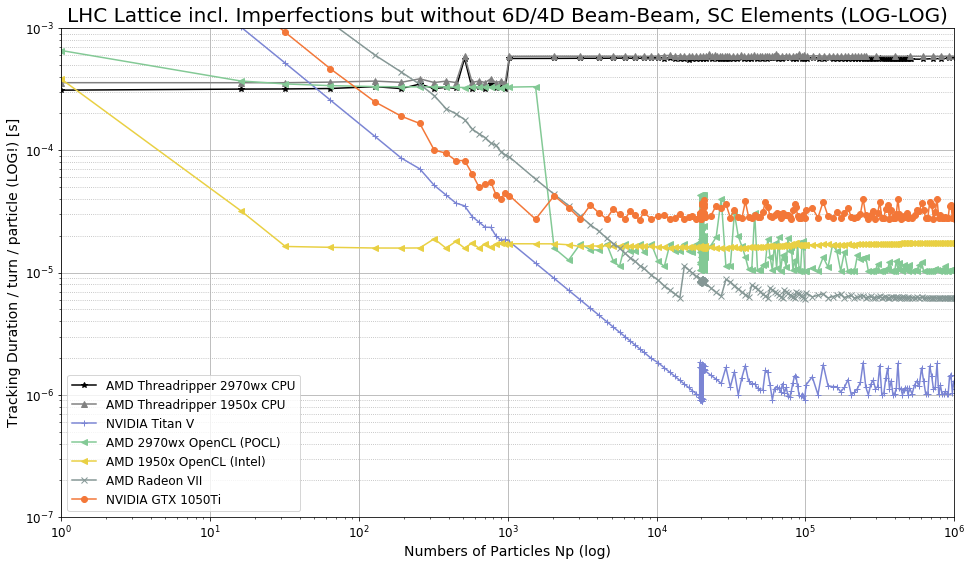

In [11]:
plt = plot_cpu_vs_ocl_all_enabled_log_log(plt, files)
plt.rcParams["figure.figsize"]=(16,9)

<div id="slide08">
    <img src="./images/performance_analysis_2_header.svg" />
</div>

In [12]:
def plot_cpu_vs_ocl_all_none_enabled_log_log(plt, data):
    ax = plt.plot(
        data["pcbe-abp-gpu001"]["cpu"]["num_particles"], data["pcbe-abp-gpu001"]["cpu"]["time"],
        label='AMD Threadripper 2970wx CPU', color='k', marker='*', markevery=1)
    
    plt.plot(
        data["pcbe15600"]["cpu"]["num_particles"], data["pcbe15600"]["cpu"]["time"],
        label='AMD Threadripper 1950x CPU', color='gray', marker='^', markevery=1)
    
    plt.plot(
        data["pcbe-abp-gpu001"]["ocl_titanv_all"]["num_particles"], 
        data["pcbe-abp-gpu001"]["ocl_titanv_all"]["time"],
        label='NVIDIA Titan V', color='#7b85d4', linestyle='--')
    
    plt.plot(
        data["pcbe-abp-gpu001"]["ocl_titanv_none"]["num_particles"], 
        data["pcbe-abp-gpu001"]["ocl_titanv_none"]["time"],
        label='NVIDIA Titan V (Disabled Beam-Fields)', color='#7b85d4', marker='+', markevery=1, linestyle="-")
            
    plt.plot(
        data["pcbe15600"]["ocl_radeonvii_all"]["num_particles"], 
        data["pcbe15600"]["ocl_radeonvii_all"]["time"],
        label='AMD Radeon VII', color='#859795', linestyle='--')
    
    plt.plot(
        data["pcbe15600"]["ocl_radeonvii_none"]["num_particles"], 
        data["pcbe15600"]["ocl_radeonvii_none"]["time"],
        label='AMD Radeon VII (Disabled Beam-Fields)', color='#859795', marker='x', markevery=1, linestyle="-")
    
    
    plt.xlim(1,1e6)
    plt.ylim(0.1e-6,1e-3)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('Numbers of Particles Np (log)',fontsize="14")
    plt.ylabel('Tracking Duration / turn / particle (LOG!) [s]',fontsize="14" )
    plt.title('LHC Lattice incl. Imperfections but without 6D/4D Beam-Beam, SC Elements (LOG-LOG)',fontsize="20")
    
    plt.tick_params(axis='x', labelsize='12')
    plt.tick_params(axis='y', labelsize='12')
                
    plt.grid(True, which='major', axis='x')
    plt.grid(True, which='major', axis='y')
    plt.grid(True, which='minor', axis='y', linestyle=':')
    
    plt.legend(fontsize=12, loc='lower left')
    return plt

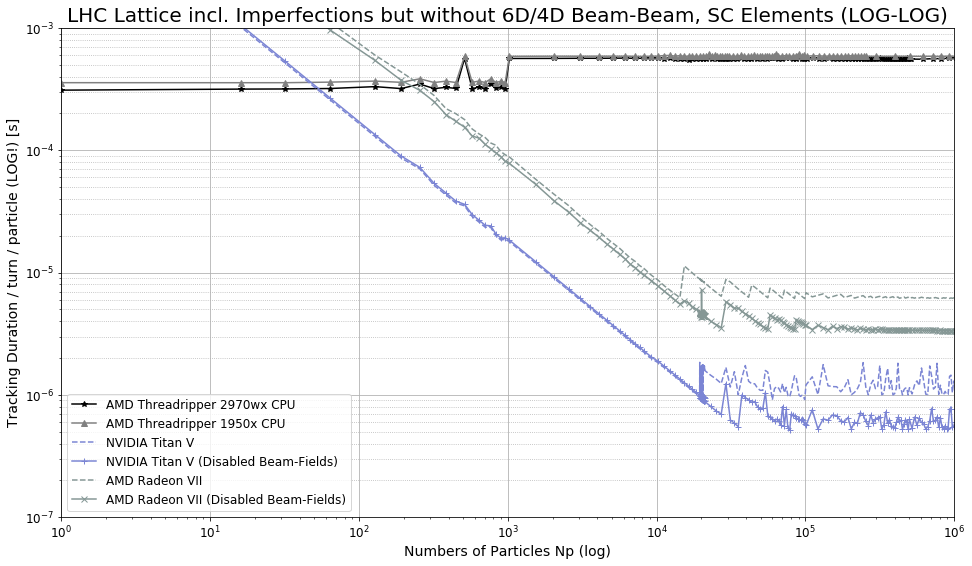

In [13]:
plt = plot_cpu_vs_ocl_all_none_enabled_log_log(plt, files)
plt.rcParams["figure.figsize"]=(16,9)

<div id="slide09">
    <img src="./images/outlook_conclusions.svg" />
</div>

<div id="slide10">
    <img src="./images/final_slide.svg" />
</div>
  
